In [2]:
# Import necessary libraries for wandb data retrieval and analysis
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Optional
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

In [3]:

# Initialize API
api = wandb.Api()

# Method 1: Get sweep object first
sweep_ids = ["lg8542ta", "s4en36ga", "pfctr47v", "ybesbkzm"]
entity = "debroue1"  # your username or team name
project = "conceptlab"

dfs = []
for sweep_id in sweep_ids:
    sweep = api.sweep(f"{entity}/{project}/{sweep_id}")

    runs = sweep.runs
    # Get all runs from the sweep
    runs_dict = []
    for run in runs:
        mmd_ratio = run.summary.get("mmd_ratio",np.nan)
        runs_dict.append({**run.config, "mmd_ratio": mmd_ratio})
    df_sweep = pd.DataFrame(runs_dict)
    dfs.append(df_sweep)
df_res = pd.concat(dfs, ignore_index=True)

wandb: Currently logged in as: debroue1 to https://genentech.wandb.io. Use `wandb login --relogin` to force relogin


In [4]:
model_dict = {"cbm": "CBM",
              "cbmfm": "CBM-FM",
              "cbmfm_raw": "CBM-FM (raw)",
              "cinemaot": "Cinema-OT"}

ct_dict = {
    'cd4': 'CD4 T cells',
    'nk': 'NK cells',
    'bcells': 'B cells',
    'cd8_tcells': 'CD8 T cells',
    'cd14_monocytes': 'CD14 Monocytes',
    'dendritic_cells': 'Dendritic Cells',
    'fcgr3a_monocytes': 'FCGR3A Monocytes',
    'megakaryocytes': 'Megakaryocytes'
}

df_res["model"] = df_res["model"].map(model_dict)
df_res["data/intervention_labels"] = df_res["data/intervention_labels"].map(ct_dict)

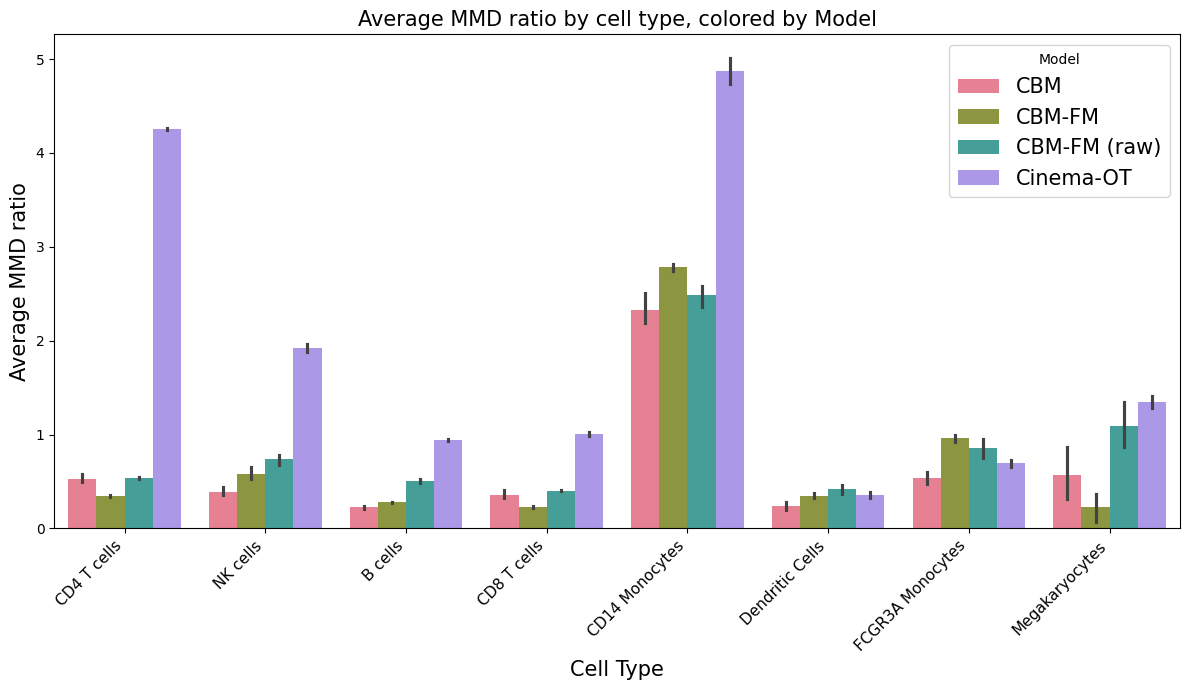

In [5]:
# Barplot: 4 bars for each cell type (one per model), aggregation over seeds, with error bars, larger font, and tilted x labels
import matplotlib.pyplot as plt
import seaborn as sns

# Check required columns
required_cols = ['data/intervention_labels', 'model', 'seed', 'mmd_ratio']
missing = [col for col in required_cols if col not in df_res.columns]
if missing:
    raise ValueError(f"Missing columns in df_res: {missing}")

# Aggregate over seeds: mean and std of mmd_ratio for each (cell type, model) pair
plot_df = df_res.groupby(['data/intervention_labels', 'model']).agg({'mmd_ratio': ['mean', 'std']}).reset_index()

plt.figure(figsize=(12,7))
ax = sns.barplot(
    data=df_res,
    x='data/intervention_labels',
    y='mmd_ratio',
    estimator="mean",
    hue='model',
    palette='husl',
 )

plt.title('Average MMD ratio by cell type, colored by Model', fontsize=15)
plt.ylabel('Average MMD ratio', fontsize=15)
plt.xlabel('Cell Type', fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.legend(title='Model', fontsize=15)
plt.tight_layout()
plt.show()